# Project 2 Regression Challenge
## Daniel Rossetti

# 0 - Problem Statement:

This is report is written from the standpoint of a data science consultant who has been hired by Zillow to prototype a home sale price estimator that can be used by website users to estimate the value of their home.  Home sale data from Ames, Iowa have been provided as a starter set and include information on almost 80 different attributes of the home or the sale itself.  This data will be used to train a linear regression model which will use a subset of these attributes to predict a home sale price.  The model quality will be evaluated against the mean average error of the predictions on the training dataset selected.  The target error is to be within $30,000 of the actual home price on average.  If successful, the methods used to create this prototype model will be employed to predict home values in other areas of the country to understand it's general applicability with the ultimate goal of being rolled out onto the Zillow website for users.

If time allows, this model will also examine the effect of time, indicating a shift in greater housing market trends, on the model.

## <font color = 'red'>Notes:
* <font color = 'red'>Go back and check the metric if it should be mean average percent error or mean average error

# 1 - Import Libraries and Read Data

In [115]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [116]:
# Read Training Data
train = pd.read_csv('../datasets/train.csv')

# Retrieve the shape of the dataset to evaluate size
print(train.shape)

train.head()

(2051, 81)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [117]:
# Read Test Data
test = pd.read_csv('../datasets/test.csv')

# Retrieve the shape of the dataset to evaluate size
print(test.shape)
test.head()

(878, 80)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


# 2 - Data Pre-processing and Preliminary Model Feature Selection

### Strategy:
* Initial checks and evaluations must be performed on the whole dataset
* Light data cleaning will occur to remove data that are not usable
* Analysis will be performed prior to down-selecting the attributes (columns / features) that will be used in the first model

## 2.1 - Check Dataframe Integrity, Check for Null Values

### 2.1.1 - Check Data Integrity (Data Types)

In [118]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

Most of the features are of the correct data type save for the following which need to be reassigned:
* MS SubClass - The building class is actually a categorical variable and needs to be turned into an object
    * Change this to an object type (convert to string)
* Mo Sold - The month sold is also a categorical variable
    * Change this to an object type (convert to string)
    
Other Categories: <br/>
'Overall Qual' and 'Overall Cond' are technically categorical variables, but as they are discrete numerical variables which effectively establish a quality/condition spectrum, it could be argued that these should be left as numerical datatypes.
* For now, they will be kept as numerical

Some Variables ('Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars') are float values when they likely shoudl be represented as integers.  The code below will investigate what float values if any are present.

In [119]:
# The code below creates a list of items in each catgeory (column) which will have a remainder greater than 0 when divided by 1
#  This will indicate if the number is truly a decimal or if something else is happening.  It's then converted to a set.
print(set([i for i in train['Bsmt Full Bath'] if i % 1 != 0]))
print(set([i for i in train['Bsmt Half Bath'] if i % 1 != 0]))
print(set([i for i in train['Garage Yr Blt'] if i % 1 != 0]))
print(set([i for i in train['Garage Cars'] if i % 1 != 0]))

{nan, nan}
{nan, nan}
{nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan}
{nan}


From this, NaN values (which are technically float64) are causing these columns to be float instead of integer.  Overall, these values are fine, but the null values should now be checked.

Below, 'MS SubClass' and 'Mo Sold' will be converted to objects.

In [120]:
# Convert MS SubClass and Mo Sold to objects, using list comprehension
train['MS SubClass'] = [str(i) for i in train['MS SubClass']]
train['Mo Sold'] = [str(i) for i in train['Mo Sold']]
test['MS SubClass'] = [str(i) for i in test['MS SubClass']]
test['Mo Sold'] = [str(i) for i in test['Mo Sold']]

print(train[['MS SubClass', 'Mo Sold']].info())
print(test[['MS SubClass', 'Mo Sold']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MS SubClass  2051 non-null   object
 1   Mo Sold      2051 non-null   object
dtypes: object(2)
memory usage: 32.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MS SubClass  878 non-null    object
 1   Mo Sold      878 non-null    object
dtypes: object(2)
memory usage: 13.8+ KB
None


### 2.1.2 - Check for Null Values, Drop Affected Columns

In [121]:
# There are about 80 columns, make a dataframe so we can filter only those columns with no null values

# Create a dataframe from the summed isnull() results for the train and test data
train_nulls = pd.DataFrame(train.isnull().sum())
test_nulls = pd.DataFrame(test.isnull().sum())

# Bring these dataframes together into a new dataframe
nulls = pd.DataFrame()
nulls['train'], nulls['test'] = train_nulls, test_nulls        

# Make percent columns so it's easier to decipher impact on dataset
nulls['train_pcnt'], nulls['test_pcnt'] = nulls['train'] / train.shape[0] * 100, nulls['test'] / test.shape[0] * 100

# Filter the dataframe to show only the columns in each with null values
nulls[(nulls['train'] != 0) | (nulls['test'] != 0)].sort_values('train', ascending = False)

,train,test,train_pcnt,test_pcnt
Pool QC,2042,874.0,99.561190,99.544419
Misc Feature,1986,837.0,96.830814,95.330296
Alley,1911,820.0,93.174061,93.394077
Fence,1651,706.0,80.497318,80.410023
Fireplace Qu,1000,422.0,48.756704,48.063781
Lot Frontage,330,160.0,16.089712,18.223235
Garage Finish,114,45.0,5.558264,5.125285
Garage Qual,114,45.0,5.558264,5.125285
Garage Cond,114,45.0,5.558264,5.125285
Garage Yr Blt,114,45.0,5.558264,5.125285


Some catageories are substantially under-populated and should be removed.  Those with null counts exceeding 10% of the data, will be eliminated (dropped).  Smaller amounts of null values in each dataframe may be acceptable depending on which featuers are chosen for the selected model(s).  They will be dropped later if needed.

The above dataframe can be filtered to yield the columns that need to be removed.

In [122]:
# Filter the "nulls" dataframe on the 10% criteria
drop_nulls = nulls[(nulls['train_pcnt'] >= 10) | (nulls['test_pcnt'] >= 10)].sort_values('train', ascending = False)

# Make a variable which is a list (index's are their own objects) of the columns matching the above criteria.
drop_cols = list(drop_nulls.index)
drop_cols

['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu', 'Lot Frontage']

In [123]:
# Drop columns from both training and test data:
train.drop(columns = drop_cols, inplace = True);
test.drop(columns = drop_cols, inplace = True);

## 2.2 - First-Pass Evaluation of Feature Importance

### 2.2.1 - Correlation with Sales Price
The correlation method will likely provide some quick insight as to which columns have the biggest impact (from a quantitative perspective) on the home sale price.

The source below establishes correlations with magnitudes greater than 0.4 to be "moderate" correllations.  A correlation method will be run on train data, and correlation coefficients will be provided relative to the sale price.  Only features with correaltion coefficient magnitudes greater than 0.4 (meaning > 0.4 OR < -0.4) will be identified.

**NOTE: This will only work for numerical variables as the data currently stand**

https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module9-Correlation-Regression/PH717-Module9-Correlation-Regression4.html

In [124]:
# Run correaltion method on train dataset, selecting the 'SalePrice' column
sale_pr_corr = train.corr()['SalePrice']

# Filter coefficients that are 'moderate' or stronger
sale_pr_corr[(sale_pr_corr >= 0.4) | (sale_pr_corr <= -0.4)]

# Define list of features from the index to eventually check for colinearity in a correlation matrix
prelim_features = sale_pr_corr[(sale_pr_corr >= 0.4) | (sale_pr_corr <= -0.4)].index

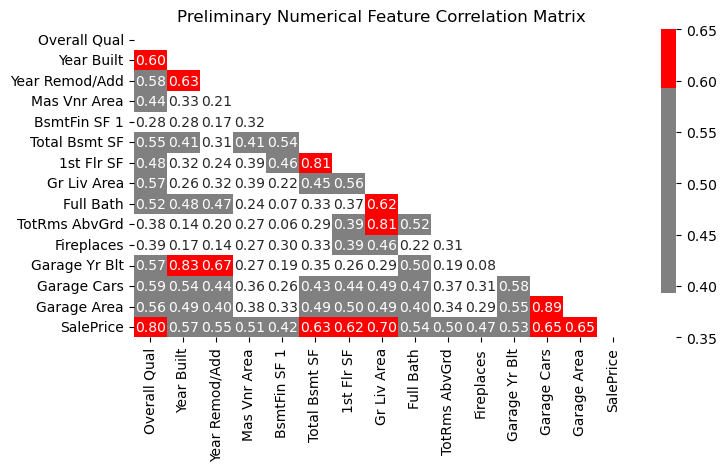

In [125]:
# Plot the correlation map between features

import matplotlib.colors

#this souce needs to be cited!!!!!
cmap2 = matplotlib.colors.ListedColormap(['white','white','white','gray','gray','gray','gray','gray','gray',
                                  'gray','gray','gray','gray','gray','gray','gray',
                                  'gray','red','red','red', 'red'])

# Show onlt bottom left of heatmap
# From Lesson 1.07 - # This code is taken with minor modifications from https://seaborn.pydata.org/generated/seaborn.heatmap.html
mask = np.zeros_like(train[prelim_features].corr())
mask[np.triu_indices_from(mask)] = True


plt.figure(figsize=(8,4))
plt.title('Preliminary Numerical Feature Correlation Matrix')
sns.heatmap(train[prelim_features].corr(),
            annot = True, 
            vmin = 0.35, vmax = .65,
            fmt='.2f', 
            cmap = cmap2, 
            mask = mask);

# Source for "fmt='.2f'":  https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format

# This is from code I wrote for another program, but I'm not sure where I got the sources from:  
# use the code here, and these sources to cobble something together.
#  Source:  https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
#  Source:  https://matplotlib.org/stable/gallery/color/named_colors.html
#  Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
#  Source:  https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.colorbar


# sns.heatmap(df.corr(),annot=True,fmt='.2f',cmap=cmap2,vmin=-1, vmax=1, annot_kws={"size":6}) #write your code here
# plt.title('Correlation Coefficients Above/Below +/-0.7')
# plt.show()




In [126]:
prelim_features

Index(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'SalePrice'],
      dtype='object')

In [127]:
set(train.corr().index) - set(prelim_features)

{'2nd Flr SF',
 '3Ssn Porch',
 'Bedroom AbvGr',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Bsmt Unf SF',
 'BsmtFin SF 2',
 'Enclosed Porch',
 'Half Bath',
 'Id',
 'Kitchen AbvGr',
 'Lot Area',
 'Low Qual Fin SF',
 'Misc Val',
 'Open Porch SF',
 'Overall Cond',
 'PID',
 'Pool Area',
 'Screen Porch',
 'Wood Deck SF',
 'Yr Sold'}

#### 2.2.1.1 - Numerical Feature Selection

Check for colinearity:  Examine correlations above 0.6 ("strong" correlations) above between features that are not the target.  Where features are colinear, choose the better one to use in the model and list the rationale.
1. Year Built vs. Overall Qual:  Newer house, better quality.
    * USE QUALITY - Quality seems to track better with SalePrice
2. Year Built vs. Year Remod/Add:  Makes sense that these would correlate as they may be the same number since Year Remod/Add defaults ot the build date if there was nothing added or remodeled
    * USE YEAR REMOD/ADD - Lower correlation with garage built (though still high)
3. Year Built vs. Garage Yr Built:  High correlation would suggest that many times, the garage is built with the house
    * DON'T USE GARAGE YR BUILT - Garage Yr Built may not be a very useful feature in this model.  Garage Cars is a better feature to use if you want to limit the number of garage features since it correlates better with sale price
4. Year Remod/Add vs. Garage Yr Built:  Lower but still strong correlation between the remodel data and the garage build.  Would suggest that many house additions were actually garages
    * USE YEAR REMOD/ADD - Stated previously
5. 1st Flr SF vs. Total Basement SF:  It makes sense that the first floor and basement have approximately the same sqaure footage.  Basement square footage correlates a bit better with sale price.
    * USE Total Basement SF:  Later, Gr Liv Area is a bette measure of home sqaure footage.  Basement is not included in this measure and will act as a unique basement feature.
6. GR Liv Area vs. Full Bath:  It makes sense that these would correlate.  Not clear on whether one or the other should be used
    * TBD
7. GR Liv Area vs. TotRms AbvGrd:  Very strong correlation, preference would be to keep square footage, especially since it correlates better with sale price (0.7 vs 0.5 correlation coefficients)
    * Use Gr Liv Area
8. Garage Area and Garage Cars:  More cars, more area.
    * Use Garage Area because correaltion with sale price is equivalent to that of the number of garage cars but keeps with the square footage theme above
    
Review the remaining features which have correlations magnitudes above 0.4 relative to the target variable, sale price.
* BsmtFin SF 1 - DO NOT USE:  This is only for a type 1 basement, and seems redundnat to total basement square footage (conceptually if no numerically)
* Full Bath - DO NOT USE:  This is too strongly correlated with above grade sqaure footage which is conceptually a better metric
* Mas Vnr Area - MAYBE USE:  Masonry could be indicative of a more expensive house.  Compare against other features later
* Fireplaces - MAYBE USE:  Fireplaces could be indicative of a more expensive house.  Compare against other features later

List of numerical features to be considered:
* Overall Quality
* Year Remod/Add
* Total Basement SF
* Gr Liv Area
* Garage Area
* Mas Vnr Area (MAYBE)
* Fireplaces (MAYBE)


DO NOT USE:
* Garage Yr Blt
* 1st Flr SF
* Garage Cars
* TotRms AbvGrd
* Year Built
* BsmtFin SF 1
* Full Bath

Remaining Numerical Variables:


* 2nd Flr SF - DO NOT USE - total SF is a better metric
* 3Ssn Porch - MAYBE
* Bedroom AbvGr - MAYBE - could be redundant with Total SF
* Bsmt Full Bath - MAYBE - not all basements have bathrooms
* Bsmt Half Bath - MAYBE - not all basements have bathrooms
* Bsmt Unf SF - DO NOT USE - Redundant with total basement SF
* BsmtFin SF 2 - DO NOT USE - Only for a type 2 basement and redundant with total basement SF
* Enclosed Porch - MAYBE
* Half Bath - DO NOT USE - Same reason as full bathrooms above
* Id - DO NOT USE - this is just an identifier for each house and is not a real feature
* Kitchen AbvGr - MAYBE
* Lot Area - USE THIS! - this should indicate how much land is attached to said home
* Low Qual Fin SF - Maybe?  This could be a modifier or possibly a feature could be made from this (like a percentage of the total square feet)
* Misc Val - MAYBE - But, likely not a good candidate of a first pass model
* Open Porch SF - MAYBE
* Overall Cond - MAYBE - Seems redundant with overall quality
* PID -  DO NOT USE - this is just an identifier for each house and is not a real feature
* Pool Area - USE THIS! - Everybody loves a pool!
* Screen Porch - MAYBE
* Wood Deck SF - USE THIS! - Decks should add value
* Yr Sold - USE THIS!  Might be needed for economic conditions given the timeframe being right around the housing bubble.

### 2.2.2 Other Numerical Features
Want to include somehjting from each of the main home feature categories (kitchen, driveway, general, basement, garage, etc.)

<font color = 'red'> TALK ABOUT CONDITION REMAINING ENCODED AS A NUMBER

### 2.2.3 - Categorical Variable Selection Discussion and Encoding

The remaining ___ insert number here __ features are categorical in nature due to tehhir object type.

Of those, many were considered for inclusion in this model, however, as most will need to be one-hot encoded, the number of feauters will dramatically increase as some of these features have a high number of unique values.  

The target is to keep the total number of featuers at or below the square root of the total number of samples.  With a total number of samples at 2051, this will have our maximum number of features at 45.

Since all features cannot ___ easily ___ be one-hot encoded and correlated to the sale price, practical decisions were made on the relevance of each catgorical variable.  One thing that was considered is general category of each variable which specifically refers to which part of the 'home' the variable concerns such as the kitchen, deck, basement, garage, general home, and even some time based variables.  Part of the selection philosophy was to include variables from as many of these categories as possible in order to have a holistic representation of all aspects which could influence the home value (and therefore the sale price).  Even from this, some categories had to be excluded in favor of features which are reasonably perceived to be of higher relevance to the home value.

The categories below were selected as initial model features and are broken down into which are one-hot encoded, and which are number encoded.  These will be encoded in a subsequent section.

Selected features which must be one-hot encoded:
* 'Utilities'
* 'Neighborhood'
* 'Bldg Type'
* 'House Style'
* 'Paved Drive'

Features representing a spectrum of quality or condition which could be encoded as numbers with higher numbers representing higher quality:
* 'Exter Cond'
* 'Heating QC'
* 'Kitchen Qual'


### 2.2.4 - Initial Data Dictionary and Feature Selection Information

This table combines the selection of numerical and catgeorical variables

Extended feature count represents the final feature count after encoding (one-hot or other)


| Var_name         | dtype   | Ext. Ft. Count | Codebook / Data Dictionary:                                                            | Category | Rationale            |
|------------------|---------|----------------|----------------------------------------------------------------------------------------|----------|----------------------|
|  'Total Bsmt SF' | float64 | 1              | TotalBsmtSF: Total square feet of basement area                                        | Basement | High Corr.           |
|  'Garage Area'   | float64 | 1              | GarageArea: Size of garage in square feet                                              | Garage   | High Corr.           |
|  'Lot Area'      | int64   | 1              | LotArea: Lot size in square feet                                                       | Lot      | Practical Importance |
|  'Overall Qual'  | int64   | 1              | OverallQual: Overall material and finish quality                                       | General  | High Corr.           |
| 'Year Remod/Add' | int64   | 1              | YearRemodAdd: Remodel date (same as construction date if no remodeling or   additions) | Time     | Mod Corr             |
| 'Gr Liv Area'    | int64   | 1              | GrLivArea: Above grade (ground) living area square feet                                | General  | High Corr.           |
|  'Bedroom AbvGr' | int64   | 1              | Bedroom: Number of bedrooms above basement level                                       | Bedroom  | Practical Importance |
|  'Wood Deck SF'  | int64   | 1              | WoodDeckSF: Wood deck area in square feet                                              | Deck     | Practical Importance |
|'Pool Area'       | int64   | 1              | PoolArea: Pool area in square feet                                                     | Pool     | Practical Importance |
|  'Misc Val'      | int64   | 1              | MiscVal: $Value of miscellaneous feature                                               | Other    | Direct Value Measure |
|  'Yr Sold'       | int64   | 1              | YrSold: Year Sold                                                                      | Time     | Time Sensitivity     |
| 'Neighborhood'   | object  | 27             | Neighborhood: Physical locations within Ames city limits                               | Location | Practical Importance |
|  'Bldg Type'     | object  | 4              | BldgType: Type of dwelling                                                             | General  | Practical Importance |
| 'Exter Cond'     | object  | 1              | ExterCond: Present condition of the material on the exterior                           | Exterior | Practical Importance |
|  'Heating QC'    | object  | 1              | HeatingQC: Heating quality and condition                                               | Heating  | Practical Importance |
|  'Kitchen Qual'  | object  | 1              | KitchenQual: Kitchen quality                                                           | Kitchen  | Practical Importance |
|  'Paved Drive'   | object  | 2              | PavedDrive: Paved driveway                                                             | Driveway | Practical Importance |

Codebook / Data Dictionary Entries Taken Direct from the Kaggle Competition Site:  https://www.kaggle.com/competitions/dsir-320-project-2-regression-challenge/data

### 2.2.5 - Creating the Initial Model Dataframe

Prior to encoding, a dataframe with all features data must be made.

In [128]:
# Create a list of the desired features

features_init = ['SalePrice',
                 'Total Bsmt SF',
                 'Garage Area',
                 'Lot Area',
                 'Overall Qual',
                 'Year Remod/Add',
                 'Gr Liv Area',
                 'Bedroom AbvGr',
                 'Wood Deck SF',
                 'Pool Area',
                 'Misc Val',
                 'Yr Sold',
                 'Neighborhood',
                 'Bldg Type',
                 'Exter Cond',
                 'Paved Drive']

In [129]:
init_data = train[features_init]

In [130]:
init_data.head()

,SalePrice,Total Bsmt SF,Garage Area,Lot Area,Overall Qual,Year Remod/Add,Gr Liv Area,Bedroom AbvGr,Wood Deck SF,Pool Area,Misc Val,Yr Sold,Neighborhood,Bldg Type,Exter Cond,Paved Drive
0,130500,725.0,475.0,13517,6,2005,1479,3,0,0,0,2010,Sawyer,1Fam,TA,Y
1,220000,913.0,559.0,11492,7,1997,2122,4,0,0,0,2009,SawyerW,1Fam,TA,Y
2,109000,1057.0,246.0,7922,5,2007,1057,3,0,0,0,2010,NAmes,1Fam,Gd,Y
3,174000,384.0,400.0,9802,5,2007,1444,3,100,0,0,2010,Timber,1Fam,TA,Y
4,138500,676.0,484.0,14235,6,1993,1445,3,0,0,0,2010,SawyerW,1Fam,TA,N


#### 2.2.3.1 - One Hot Encoding Variables

In [131]:
# Print the unique values for each category and make sure that the data look correct
for i in ['Neighborhood', 'Bldg Type', 'Paved Drive']:
    print(init_data[i].unique())

['Sawyer' 'SawyerW' 'NAmes' 'Timber' 'Edwards' 'OldTown' 'BrDale'
 'CollgCr' 'Somerst' 'Mitchel' 'StoneBr' 'NridgHt' 'Gilbert' 'Crawfor'
 'IDOTRR' 'NWAmes' 'Veenker' 'MeadowV' 'SWISU' 'NoRidge' 'ClearCr'
 'Blmngtn' 'BrkSide' 'NPkVill' 'Blueste' 'GrnHill' 'Greens' 'Landmrk']
['1Fam' 'TwnhsE' 'Twnhs' '2fmCon' 'Duplex']
['Y' 'N' 'P']


In [132]:
# One hot encode categorical variables which are not going to be encoded as numbers.
# Note, after some checking, drop_first appears to drop the desired columns for Bloomington, Single Family Homes, and Unpaved Driveways
init_data = pd.get_dummies(columns=['Neighborhood', 'Bldg Type', 'Paved Drive'],
               data = init_data,
              drop_first= True
              )

In [133]:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalePrice             2051 non-null   int64  
 1   Total Bsmt SF         2050 non-null   float64
 2   Garage Area           2050 non-null   float64
 3   Lot Area              2051 non-null   int64  
 4   Overall Qual          2051 non-null   int64  
 5   Year Remod/Add        2051 non-null   int64  
 6   Gr Liv Area           2051 non-null   int64  
 7   Bedroom AbvGr         2051 non-null   int64  
 8   Wood Deck SF          2051 non-null   int64  
 9   Pool Area             2051 non-null   int64  
 10  Misc Val              2051 non-null   int64  
 11  Yr Sold               2051 non-null   int64  
 12  Exter Cond            2051 non-null   object 
 13  Neighborhood_Blueste  2051 non-null   uint8  
 14  Neighborhood_BrDale   2051 non-null   uint8  
 15  Neighborhood_BrkSide 

In [ ]:
# 

#### 2.2.3.2 - Number Encoding Variables

In [18]:
len(train.columns)

75

Basement - 1
Bathroom - 0, was determined to be colinear with another variable or not useful
Bedroom - 1
Building - 1
Deck - 1
Driveway
Electrical
Exterior - 1
Fireplace - 1
Foundation
Functionality
Garage - 1
General - 1+
Heating - 1
Kitchen - 1
Location - 1
Lot - 1
MISC
Other - 1
Pool - 1
Porch
Price
Roof
Time - 1
Utilities - 1


<AxesSubplot:>

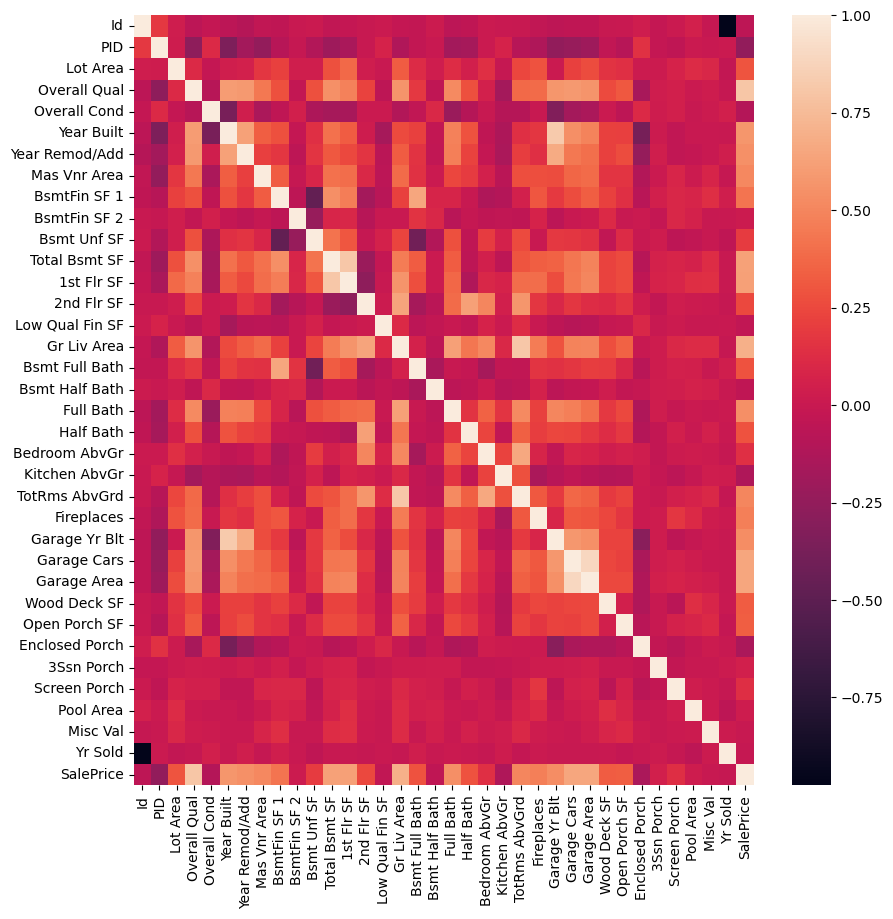

In [19]:

plt.figure(figsize=(10, 10))
sns.heatmap(train.corr())

In [20]:
# View a list of the columns to refer back to for proper spelling while coding
train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type',
       'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area',
   

In [21]:
train['Yr Sold'].value_counts()

2007    498
2009    446
2006    438
2008    435
2010    234
Name: Yr Sold, dtype: int64

In [22]:
test.shape

(878, 74)

# Appendix A - Relevant Outside Research Conclusions
Below are a list of conclusions derivded from research sources found on the internet that are pertinent to the analysis above:
* The garage does NOT count towards total sqaure footage: https://raleighrealtyhomes.com/blog/measure-square-footage/#:~:text=Does%20the%20garage%20count%20in,converted%20into%20a%20living%20space.
* The basement does NOT count towards the total square footage:  https://www.realtor.com/advice/buy/does-basement-count-square-footage-of-a-home/#:~:text=Does%20a%20basement%20count%20toward,that%20means%20below%20ground%20level.
* Townhouse end units worth more:  https://firsthousecoach.com/is-an-end-unit-townhouse-worth-more/#:~:text=The%20Differences%20Between%20An%20End%20Unit%20VS.&text=More%20than%20likely%2C%20you%20will,be%20desirable%20for%20many%20people.
* Importance of Neighborhood in home value:  https://www.opendoor.com/articles/factors-that-influence-home-value



<font color= 'red'>STRING OF TEXT

In [29]:
#init_data[['Utilities', 'Neighborhood', 'Bldg Type', 'House Style', 'Paved Drive']].unique()

init_data['Utilities'].unique()

unique_var = pd.DataFrame(columns=['Utilities', 'Neighborhood', 'Bldg Type', 'House Style', 'Paved Drive'])

# for i in ['Utilities', 'Neighborhood', 'Bldg Type', 'House Style', 'Paved Drive']:
#     unique_var.merge(pd.Series(init_data[i].unique(), name = i), 'outer')

# df = pd.DataFrame()


# Sourece for unique:  https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns/#:~:text=You%20can%20get%20unique%20values,to%20get%20from%20multiple%20columns.
# Also used doc string for code below

# pd.Series(init_data['Utilities'].unique())

pd.Series(init_data['Utilities'].unique(), name = 'Utilities').index

unique_var = unique_var.merge(pd.Series(init_data['Utilities'].unique(), name = 'Utilities'), 'outer', on = pd.Series(init_data['Utilities'].unique(), name = 'Utilities').index)
unique_var = unique_var.merge(pd.Series(init_data['Neighborhood'].unique(), name = 'Neighborhood'), 'outer', on = pd.Series(init_data['Utilities'].unique(), name = 'Neighborhood').index)


# unique_var

KeyError: RangeIndex(start=0, stop=3, step=1)